In [3]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

from torch.utils.data import TensorDataset
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

import pickle 
with open('mapping.pkl', 'rb') as file:
    mappingDict = pickle.load(file)

c:\Users\eric7\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\eric7\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
class preLearnedFungaV1(nn.Module):
    def __init__(self):
        super(preLearnedFungaV1, self).__init__()
        self.name = "fungaV1"
        #added anther convolution channel before fc layers
        self.conv1 = nn.Conv2d(256, 128, 3, 1, 1)
        self.fc1 = nn.Linear(128*6*6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        #dropout implementation
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)

        #FC layers
        x = self.dropout2(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))

        x = self.dropout4(x)
        x = self.fc3(x)
        x = x.squeeze(1)  
        return x
def get_model_name(name, batch_size, lr, epoch):
    path = "modelStorage/model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, lr, epoch)
    return path

def testOutModel(image):
    BATCH_SIZE = 32
    LEARNING_RATE = 0.0003
    BEST_EPOCH = 110
    n = 10
    bestNet = preLearnedFungaV1()
    model_path = get_model_name("fungaV1", batch_size=BATCH_SIZE, lr=LEARNING_RATE, epoch=BEST_EPOCH)
    state = torch.load(model_path)
    bestNet.load_state_dict(state)

    featureExtraction = alexnet.features(transform(Image.open(image)))
    bestNet.eval()
    with torch.no_grad():
        output = bestNet(featureExtraction.unsqueeze(0))
    print(f"\n\n{output}")
    modelPrediction = torch.max(output, 1)
    print("\n\nModel Prediction:")

    return mappingDict[modelPrediction[1].item()]


Cookeina tricholoma



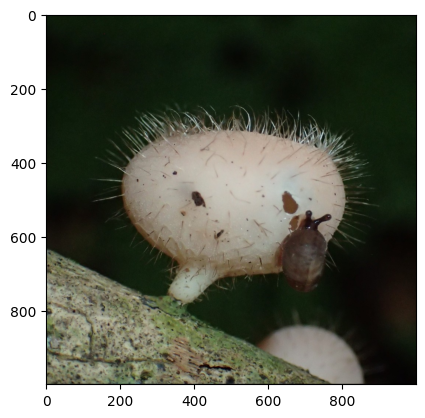



tensor([[14.4878,  0.5513,  2.5745, -3.3065, -1.5902, -7.0170,  3.3682, -6.4240,
         -2.9283,  0.3624]])


Model Prediction:
the model classifies the mushroom as: Cookeina tricholoma


In [25]:
#Test out the function
df_test = pd.read_csv("../data/set_test.csv")
grouped_testing = df_test.groupby('Genus')['Path'].apply(list).to_dict()
mapping_testing = {key: np.array(value) for key, value in grouped_testing.items()}

import matplotlib.pyplot as plt 
#Choose A Key
chosenKey = "Cookeina tricholoma"
#Choose an image from key
firstImage = mapping_testing[chosenKey][0]

print(chosenKey)
print()
img = plt.imread(firstImage) 
plt.imshow(img) 
plt.show()  


#Call the function
output = testOutModel(firstImage)
print(f"the model classifies the mushroom as: {output}")